# RECAP

- Implement early stopping.
- Implement interleaved training and evaluation rollouts.
- Update seeding from global to local.

# Trio Task


## Goal:

### Agents must learn how to navigate to a target landmark, while avoiding other agents.

- Both agents and landmarks are restarted at the begining of each episode. And agents are assigned a landmark they must navigate to, they must through trial and error be find which landmark they were assigned to.
- States are the coordinates to the other agent and to both landmarks.
- Reward is defined by the distance from an agent to its assigned landmark. If they collide both receive an extra reward=-1.


### General MDP

$$\mathcal{X} = \mathcal{X}_1 \times \mathcal{X}_2\times \mathcal{X}_3$$
$$\mathcal{A} = \mathcal{A}_1 \times \mathcal{A}_2\times \mathcal{X}_3$$
$$r = r_1(x_1) + r_2(x_2) + r_3(x_3)$$

#### States


$$\mathcal{X}_1 = (\alpha^1_x, \alpha^1_y, v^ 1_x, v^ 1_y, l^1_x, l^1_y, l^2_x, l^2_y, , l^3_x, l^3_y) $$
$$\mathcal{X}_2 = (\alpha^2_x, \alpha^2_y, v^2_x, v^2_y, l^1_x, l^1_y, l^2_x, l^2_y, l^3_x, l^3_y) $$
$$\mathcal{X}_3 = (\alpha^3_x, \alpha^3_y, v^3_x, v^3_y, l^1_x, l^1_y, l^2_x, l^2_y, l^3_x, l^3_y) $$

#### Actions

$$\mathcal{A}_1 = (0, 1, 2, 3, 4) $$
$$\mathcal{A}_2 = (0, 1, 2, 3, 4) $$
$$\mathcal{A}_3 = (0, 1, 2, 3, 4) $$


#### Rewards

 `TODO`

### Central Learner

The central agents solves the general MDP above.

    - Single agent.
    - Fully observable setting.
    - Learnings using the average reward from both players.
<table>
<tr>
<th>Central Agent</th>
</tr>
<tr>
<td>
$$\mathcal{X}_1 \times \mathcal{X}_2\times \mathcal{X}_3$$
$$\mathcal{A}_1 \times \mathcal{A}_2\times \mathcal{A}_3$$
$$r_1(x_1) + r_2(x_2)+ r_3(x_3)$$
</td>
</tr>
</table>

### Distributed Learners

The distributed agent have full observability but learn
independently.

    - Independent agents.
    - Fully observable setting.
    - Learnings using the average reward from both players.

<table>
<tr>
<th>Agent 1</th>
<th>Agent 2</th>
<th>Agent 3</th>    
</tr>
<tr>
<td>
$$\mathcal{X}_1 \times \mathcal{X}_2\times \mathcal{X}_3$$
$$\mathcal{A}_1 $$
$$r_1(x_1) + r_2(x_2)+ r_3(x_3)$$
</td>
<td>
$$\mathcal{X}_1 \times \mathcal{X}_2\times \mathcal{X}_3$$
$$\mathcal{A}_2 $$
$$ r_1(x_1) + r_2(x_2)+ r_3(x_3)$$
</td>
<td>
$$\mathcal{X}_1 \times \mathcal{X}_2\times \mathcal{X}_3$$
$$\mathcal{A}_2 $$
$$ r_1(x_1) + r_2(x_2)+ r_3(x_3)$$
</td>
</tr>
</table>

### Independent Learner

The distributed agent have partial observability and learn
independently.

    - Independent agents.
    - Partially observable setting.
    - Individual rewards.

<table>
<tr>
<th>Agent 1</th>
<th>Agent 2</th>
<th>Agent 3</th>
</tr>
<tr>
<td>
$$\mathcal{X}_1$$
$$\mathcal{A}_1$$
$$r_1(x_1)$$
</td>
<td>
$$\mathcal{X}_2$$
$$\mathcal{A}_2 $$
$$ r_2(x_2)$$
</td>
<td>
$$\mathcal{X}_3$$
$$\mathcal{A}_3 $$
$$ r_3(x_3)$$
</td>
</tr>
</table>

# SECTION A: Settings



1. We compare the three information strucutures above. 
2. Initially, $\tau = 100$ and it falls linearly with the number of episodes (`explore_episodes=25000`). 
3. Each test dataframe consists of the DataFrame.describe() statistics from **N** = 30 independent random trials, each of which consisting of rollouts of `M=100`, with $\tau$ set to a predetermined value.

Parameters:
```
"""Configuration"""
# The hyperparameter for the environment: Number of agents.
N_AGENTS = 3
# The pipeline agent
AGENT_TYPE = 'ActorCriticCentral'
# Alpha learning rate for the critic
ALPHA = 0.5
# Learning rate for the actor
BETA = 0.3
# Final temperature parameter
TAU = 5.0
# The weighting for the moving average
ZETA = 0.01
# The episodes with temperature greater than TAU
EXPLORE_EPISODES = 10000
# The total number of training episodes.
EPISODES = 30000
# Applies temperature parameter from 100-TAU
EXPLORE = True
# Only for consensus learners
CONSENSUS_MATRIX_TYPE = 'metropolis'
# Maximum number of edges.
CONSENSUS_MAX_EDGES = 0
# Stop training at every checkpoint_interval
CHECKPOINT_INTERVAL = 500
# Evaluate checkpoint for checkpoint evaluations
CHECKPOINT_EVALUATIONS = 32
# Training_cycle = train for checkpoint interval + checkpoint_evaluation
TRAINING_CYCLES = EPISODES // CHECKPOINT_INTERVAL
# Seed for individual runs, e.g, `python central.py`
SEED = 1
# The path that the experiments will be saved at.
BASE_PATH = 'data/01_trio'
# The number of pipeline workers
N_WORKERS = 10
# Those are the training random seeds, i.e., `.\pipeline`
PIPELINE_SEEDS = [
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    68,
    69,
    70,
    71,
    72,
    73,
    74,
    75,
    76
]
```

## Declarations

In [1]:
import pandas as pd

FIG_SIZE_LARGE = (12.0, 5.0)
FIG_SIZE_SMALL = (6.0, 4.0)


def describe(dataframe: pd.DataFrame, label: str) -> pd.DataFrame:
    """Describes the dataframe
    
    Parameters
    ----------
    dataframe: pd.DataFrame
        A dataframe with description N independent rollouts.
        Each consisting of M timesteps.
        Trials are in the columns and rows are statistics.
        The result of df.describe()
   
    Returns
    -------
    dataframe: pd.DataFrame
        A description of the average return.
    
    """
    df = dataframe.drop(['std', 'count', '25%', '50%', '75%'], axis=0)
    ts = df.T.describe()['mean']
    ts.name = label
    return ts.to_frame()

## A.1) Central Agent

BASE_PATH = '01_trio_w08v2/00_central/02/'

### A.1.1 Rollout Simulation

GIF from the best performing training.

![pipeline-central-simulation](01_trio_w08v2/00_central/02/simulation-pipeline-best.gif)

### A.1.2 Rollout Graph



![pipeline-central-simulation](01_trio_w08v2/00_central/02/evaluation_rollout_n3_num27.png)

In [49]:
df = pd.read_csv('01_trio_w08v2/00_central/02/evaluation_rollout-num27.csv',sep=',')
df.sum()

Unnamed: 0    4950.00000
1              -58.67915
dtype: float64

### A.1.3 Train<a name="A-1.3"></a> 



![pipeline-central-train-12](01_trio/00_central/02/train_pipeline_m30.png)
![rollout-central-train-12](01_trio/00_central/02/train_rollout_m30.png)

### A.1.4 Collision

<AxesSubplot:title={'center':'Collisions per Episode'}, xlabel='episode'>

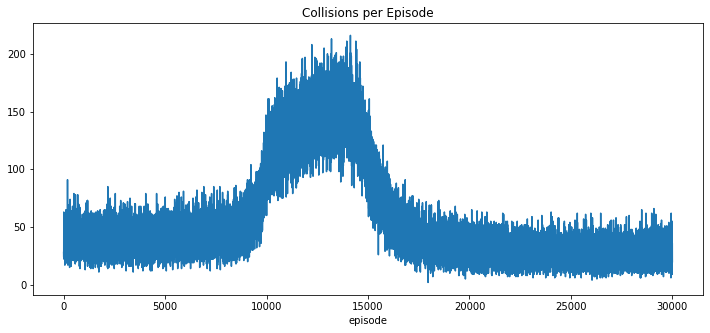

In [50]:

BASE_PATH = '01_trio_w08v2/00_central/02/'
df = pd.read_csv(BASE_PATH + '/pipeline-train-collisions.csv', sep=',', index_col=0)
df['episode'] = df.index // 100
df = df.set_index('episode', inplace=False, drop=True)
df = df.sum(axis=1).to_frame().rename(columns={0: 'collisions'})
df = df.groupby(by='episode', axis=0)['collisions'].sum()
df.to_frame().loc[:, 'collisions'].plot(title='Collisions per Episode', figsize=FIG_SIZE_LARGE)

### A.1.5 Coupling

<AxesSubplot:title={'center':'Couplings per Episode'}, xlabel='episode'>

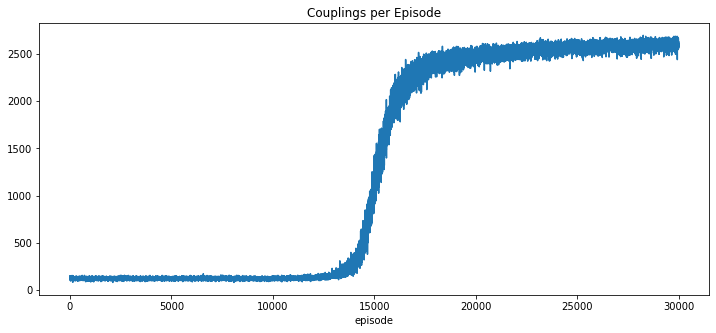

In [51]:
BASE_PATH = '01_trio_w08v2/00_central/02/'
df = pd.read_csv(BASE_PATH + '/pipeline-train-couplings.csv', sep=',', index_col=0)
df['episode'] = df.index // 100
df = df.set_index('episode', inplace=False, drop=True)
df = df.sum(axis=1).to_frame().rename(columns={0: 'couplings'})
df.head()
df = df.groupby(by='episode', axis=0)['couplings'].sum()
df.to_frame().loc[:, 'couplings'].plot(title='Couplings per Episode', figsize=FIG_SIZE_LARGE)



<AxesSubplot:title={'center':'Collisions per Episode'}, xlabel='episode'>

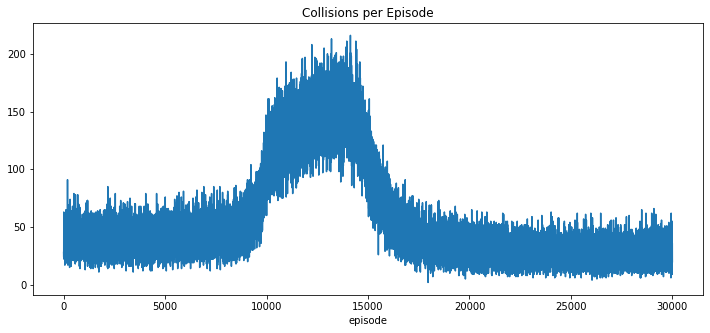

In [52]:
BASE_PATH = '01_trio_w08v2/00_central/02/'
df = pd.read_csv(BASE_PATH + '/pipeline-train-collisions.csv', sep=',', index_col=0)
df['episode'] = df.index // 100
df = df.set_index('episode', inplace=False, drop=True)
df = df.sum(axis=1).to_frame().rename(columns={0: 'collisions'})
df = df.groupby(by='episode', axis=0)['collisions'].sum()
df.to_frame().loc[:, 'collisions'].plot(title='Collisions per Episode', figsize=FIG_SIZE_LARGE)

![pipeline-central-train-12](01_trio_w08v2/00_central/02/train_pipeline_m30.png)

## A.2) Distributed Actor Critic

BASE_PATH = '01_trio_w08v2/01_distributed_learners/02/'

### A.2.1 Rollouts distributed learners

GIF from the best performing training.

![pipeline-central-simulation](01_trio_w08v2/01_distributed_learners/02/simulation-pipeline-best.gif)

### A.2.2 Rollout Graph


![pipeline-distributed-simulation](01_trio_w08v2/01_distributed_learners/02/evaluation_rollout_n3_num08.png)

In [54]:
df = pd.read_csv('01_trio_w08v2/01_distributed_learners/02/evaluation_rollout-num08.csv',sep=',')
df.sum()

Unnamed: 0    4950.000000
1              -75.902609
dtype: float64

### A.2.3 Train<a name="A-2.3"></a> 


![pipeline-distributed-train-30](01_trio_w08v2/01_distributed_learners/02/train_pipeline_m30.png)
![rollout-distributed-train-30](01_trio_w08v2/01_distributed_learners/02/train_rollout_m30.png)

### A.2.4 Collision

<AxesSubplot:title={'center':'Collisions per Episode'}, xlabel='episode'>

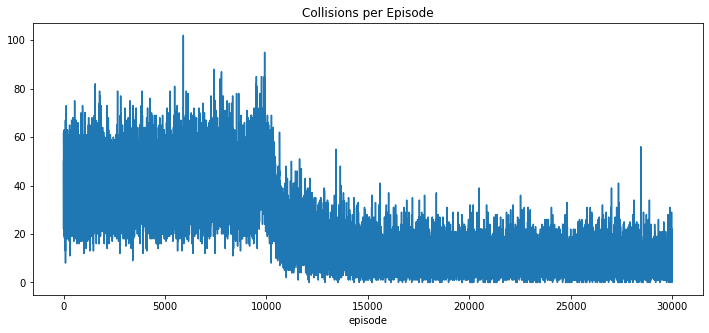

In [55]:
FIG_SIZE_LARGE = (12.0, 5.0)
FIG_SIZE_SMALL = (6.0, 4.0)
import pandas as pd
BASE_PATH = '01_trio_w08v2/01_distributed_learners/02/'
df = pd.read_csv(BASE_PATH + '/pipeline-train-collisions.csv', sep=',', index_col=0)
df['episode'] = df.index // 100
df = df.set_index('episode', inplace=False, drop=True)
df = df.sum(axis=1).to_frame().rename(columns={0: 'collisions'})
df = df.groupby(by='episode', axis=0)['collisions'].sum()
df.to_frame().loc[:, 'collisions'].plot(title='Collisions per Episode', figsize=FIG_SIZE_LARGE)

![pipeline-distributed-train-30](03_trio_collisions_and_couplings/01_distributed_learners2/02/train_pipeline_m30.png)

### A.2.5 Coupling

<AxesSubplot:title={'center':'Couplings per Episode'}, xlabel='episode'>

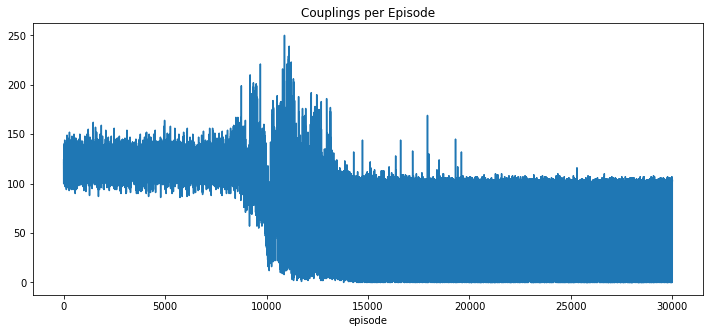

In [56]:
BASE_PATH = '01_trio_w08v2/01_distributed_learners/02'
df = pd.read_csv(BASE_PATH + '/pipeline-train-couplings.csv', sep=',', index_col=0)
df['episode'] = df.index // 100
df = df.set_index('episode', inplace=False, drop=True)
df = df.sum(axis=1).to_frame().rename(columns={0: 'couplings'})
df = df.groupby(by='episode', axis=0)['couplings'].sum()
df.to_frame().loc[:, 'couplings'].plot(title='Couplings per Episode', figsize=FIG_SIZE_LARGE)

## A.3) Independent Learners Actor Critic

BASE_PATH = '01_trio_w08v2/02_independent_learners/02/'

### A.3.1 Rollouts independent learners

GIF from the best performing training.

![pipeline-distributed-simulation](01_trio_w08v2/02_independent_learners/02/simulation-pipeline-best.gif)

### A.3.2 Rollout Graph


![pipeline-independent-rollout](01_trio_w08v2/02_independent_learners/02/evaluation_rollout_n3_num19.png)

In [61]:
df = pd.read_csv('01_trio_w08v2/02_independent_learners/02/evaluation_rollout-num19.csv',sep=',')
df.sum()

Unnamed: 0    4950.000000
1              -47.974101
dtype: float64

### A.3.3 Train <a name="A-3.3"></a> 

![pipeline-independent-train-30](01_trio_w08v2/02_independent_learners/02/train_pipeline_m30.png)
![rollout-independent-train-30](01_trio_w08v2/02_independent_learners/02/train_rollout_m30.png)

### A.3.4 Collision

<AxesSubplot:title={'center':'Collisions per Episode'}, xlabel='episode'>

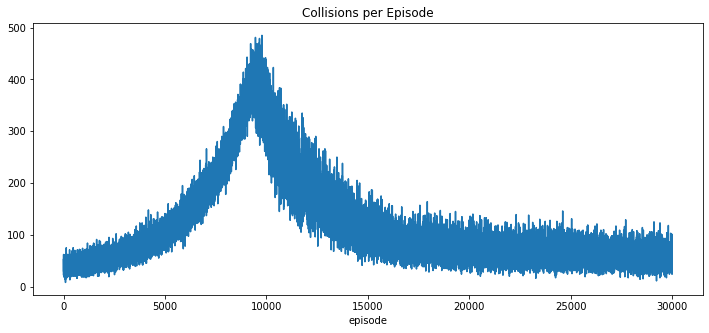

In [62]:
FIG_SIZE_LARGE = (12.0, 5.0)
FIG_SIZE_SMALL = (6.0, 4.0)
import pandas as pd
BASE_PATH = '01_trio_w08v2/02_independent_learners/02/'
df = pd.read_csv(BASE_PATH + '/pipeline-train-collisions.csv', sep=',', index_col=0)
df['episode'] = df.index // 100
df = df.set_index('episode', inplace=False, drop=True)
df = df.sum(axis=1).to_frame().rename(columns={0: 'collisions'})
df = df.groupby(by='episode', axis=0)['collisions'].sum()
df.to_frame().loc[:, 'collisions'].plot(title='Collisions per Episode', figsize=FIG_SIZE_LARGE)

### A.3.5 Coupling

<AxesSubplot:title={'center':'Couplings per Episode'}, xlabel='episode'>

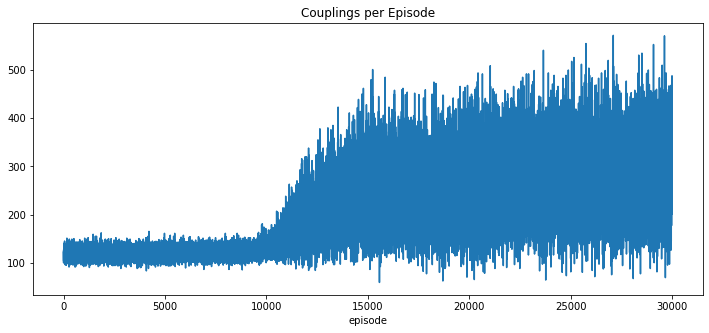

In [63]:
BASE_PATH = '01_trio_w08v2/02_independent_learners/02/'
df = pd.read_csv(BASE_PATH + '/pipeline-train-couplings.csv', sep=',', index_col=0)
df['episode'] = df.index // 100
df = df.set_index('episode', inplace=False, drop=True)
df = df.sum(axis=1).to_frame().rename(columns={0: 'couplings'})
df = df.groupby(by='episode', axis=0)['couplings'].sum()
df.to_frame().loc[:, 'couplings'].plot(title='Couplings per Episode', figsize=FIG_SIZE_LARGE)

## A.4) Consensus Learners Actor Critic

BASE_PATH = '01_trio/03_consensus/02/'

### A.4.1 Rollouts consensus learners

GIF from the best performing training.

![pipeline-distributed-simulation](01_trio/03_consensus/02/simulation-pipeline-best.gif)

### A.4.2 Rollout Graph


![pipeline-consensus-rollout](01_trio/03_consensus_learners/02/evaluation_rollout_n3_num21.png)

In [47]:
### A.4.2 Rollout Graph

df = pd.read_csv('01_trio/03_consensus_learners/02/evaluation_rollout-num21.csv', sep=',')
df.sum()

Unnamed: 0    4950.000000
1              -46.063474
dtype: float64

### A.4.3 Train <a name="A-4.3"></a> 



![pipeline-independent-train-30](01_trio/03_consensus_learners/02/train_pipeline_m30.png)
![rollout-independent-train-30](01_trio/03_consensus_learners/02/train_rollout_m30.png)

### A.4.4 Collision

<AxesSubplot:title={'center':'Collisions per Episode'}, xlabel='episode'>

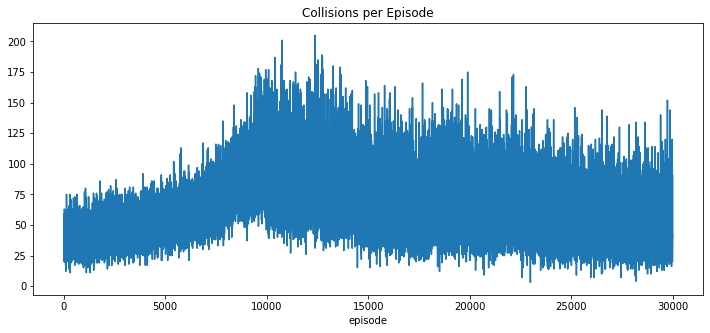

In [29]:
FIG_SIZE_LARGE = (12.0, 5.0)
FIG_SIZE_SMALL = (6.0, 4.0)
import pandas as pd
BASE_PATH = '01_trio/03_consensus_learners/02/'
df = pd.read_csv(BASE_PATH + '/pipeline-train-collisions.csv', sep=',', index_col=0)
df['episode'] = df.index // 100
df = df.set_index('episode', inplace=False, drop=True)
df = df.sum(axis=1).to_frame().rename(columns={0: 'collisions'})
df = df.groupby(by='episode', axis=0)['collisions'].sum()
df.to_frame().loc[:, 'collisions'].plot(title='Collisions per Episode', figsize=FIG_SIZE_LARGE)

### A.4.5 Coupling

<AxesSubplot:title={'center':'Couplings per Episode'}, xlabel='episode'>

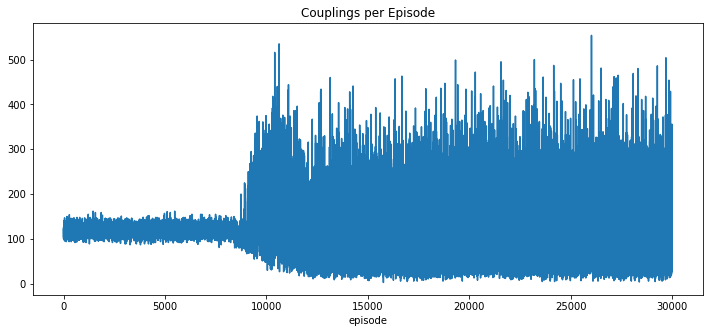

In [30]:
BASE_PATH = '01_trio/03_consensus_learners/02/'
df = pd.read_csv(BASE_PATH + '/pipeline-train-couplings.csv', sep=',', index_col=0)
df['episode'] = df.index // 100
df = df.set_index('episode', inplace=False, drop=True)
df = df.sum(axis=1).to_frame().rename(columns={0: 'couplings'})
df = df.groupby(by='episode', axis=0)['couplings'].sum()
df.to_frame().loc[:, 'couplings'].plot(title='Couplings per Episode', figsize=FIG_SIZE_LARGE)

## A.4) Leaderboard A<a name="A-leaderboard"></a> 

In [58]:
BASE_PATH = '01_trio_w08v2/'

central_df = pd.read_csv(BASE_PATH + '00_central/02/pipeline-rollouts.csv', sep=',', index_col=0)
distributed_df = pd.read_csv(BASE_PATH + '01_distributed_learners/02/pipeline-rollouts.csv', sep=',', index_col=0)
independent_df = pd.read_csv(BASE_PATH + '02_independent_learners/02/pipeline-rollouts-best.csv', sep=',', index_col=0)
#consensus_df = pd.read_csv(BASE_PATH + '03_consensus_learners/02/pipeline-rollouts-best.csv', sep=',', index_col=0)

In [64]:

dataframes = []
dataframes.append(describe(central_df.describe(), label='Central A'))
dataframes.append(describe(distributed_df.describe(), label='Distributed A'))
dataframes.append(describe(independent_df.describe(), label='Independent A'))
#dataframes.append(describe(consensus_df.describe(), label='Consensus A'))
noregdf = pd.concat(dataframes, axis=1)
noregdf

,Central A,Distributed A,Independent A
count,30.000000,30.000000,3.000000
mean,-0.983400,-1.404430,-0.898722
std,0.216777,0.433704,0.361282
min,-1.401608,-2.305033,-1.275742
25%,-1.128635,-1.651229,-1.070302
50%,-0.991817,-1.447136,-0.864862
75%,-0.801666,-1.014393,-0.710212
max,-0.586792,-0.759026,-0.555562


## Findings

* At the end of the exploration the number of collisions increases, it again decreases as the train goes on.    
     * Perhaps, this is an induced case of scheduling learning where on the first phase the agents learn how to reach the landmarks, then as they learn how to avoid collisions.
* Except for the consensus case: Decrease of performance is associated with increase in coupling -- coupling happens when all (three) agents decide to take the same action.    
     * Hypothesis from last week: They are all choosing `NOOP` (the neutral action). I really don't believe that but must show the gifs that prove it. 

### Why the more information the algorithm has the worse its performance?

## Hypothesis

* The algorithms that have more information may have more parameters.
* Could be a case of underspecified model. The function approximation being too simple for the task at hand?
     * **Zhang, et al.** use a feed forward network.
     
## Other challenges

* Using actor-critic with advantange
  * `NOOP` insert equation here